In [1]:
from tensorflow.keras.models import Model

In [2]:
from tensorflow.keras.layers import (
    Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AvgPool1D, AvgPool2D, Reshape,
    Input, Activation, BatchNormalization, Dense, Add, Lambda, Dropout, LayerNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [3]:
import numpy as np
import pandas as pd
import pickle

In [4]:
import matplotlib.pyplot as plt

In [5]:
min_idx_y = 71
max_idx_y = 150
num_classes_y = max_idx_y - min_idx_y + 1

In [6]:
with open('X_tensor.data', 'rb') as f:
    X_tensor = pickle.load(f)
with open('y_tensor.data', 'rb') as f:
    y_tensor = pickle.load(f).astype('float32')

In [7]:
def crps(y_true, y_pred):
    loss = K.mean(K.sum((K.cumsum(y_pred, axis = 1) - K.cumsum(y_true, axis=1))**2, axis=1))/199
    return loss

In [8]:
def get_conv_net(num_classes_y):
    #_, x, y, z = train_x.shape
    inputdense_players = Input(shape=(11,10,10), name = "playersfeatures_input")
    
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(inputdense_players)
    X = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(X)
    X = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(X)
    
    # The second block of convolutions learns the necessary information per defense player before the aggregation.
    # For this reason the pool_size should be (1, 10). If you want to learn per off player the pool_size must be 
    # (11, 1)
    Xmax = MaxPooling2D(pool_size=(1,10))(X)
    Xmax = Lambda(lambda x1 : x1*0.3)(Xmax)

    Xavg = AvgPool2D(pool_size=(1,10))(X)
    Xavg = Lambda(lambda x1 : x1*0.7)(Xavg)

    X = Add()([Xmax, Xavg])
    X = Lambda(lambda y : K.squeeze(y,2))(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(160, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Conv1D(96, kernel_size=1, strides=1, activation='relu')(X)
    X = BatchNormalization()(X)
    
    Xmax = MaxPooling1D(pool_size=11)(X)
    Xmax = Lambda(lambda x1 : x1*0.3)(Xmax)

    Xavg = AvgPool1D(pool_size=11)(X)
    Xavg = Lambda(lambda x1 : x1*0.7)(Xavg)

    X = Add()([Xmax, Xavg])
    X = Lambda(lambda y : K.squeeze(y,1))(X)
    
    X = Dense(96, activation="relu")(X)
    X = BatchNormalization()(X)

    X = Dense(256, activation="relu")(X)
    X = LayerNormalization()(X)
    X = Dropout(0.3)(X)

    outsoft = Dense(num_classes_y, activation='softmax', name = "output")(X)

    model = Model(inputs = [inputdense_players], outputs = outsoft)
    return model

In [9]:
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        X_valid, y_valid = self.data[0], self.data[1]

        y_pred = self.model.predict(X_valid)
        y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
        val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
        logs['val_CRPS'] = val_s
        
        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [10]:
models = []
kf = KFold(n_splits=6, shuffle=True)
score = []
histories = []

for i, (tdx, vdx) in enumerate(kf.split(X_tensor, y_tensor)):
    print(f'Fold : {i}')
    X_train, X_val = X_tensor[tdx], X_tensor[vdx]
    y_train, y_val = y_tensor[tdx], y_tensor[vdx]

    y_train = y_train.astype('float32')
    y_val = y_val.astype('float32')
    
    model = get_conv_net(num_classes_y)

    es = EarlyStopping(monitor='val_CRPS',
                        mode='min',
                        restore_best_weights=True,
                        verbose=0,
                        patience=10)
    
    es.set_model(model)
    metric = Metric(model, [es], [X_val, y_val])

    lr_i = 1e-3
    lr_f = 5e-4
    n_epochs = 30 

    decay = (1-lr_f/lr_i)/((lr_f/lr_i)* n_epochs - 1)  #Time-based decay formula
    alpha = (lr_i*(1+decay))
    
    opt = Adam(learning_rate=1e-3)
    model.compile(loss=crps,
                  optimizer=opt)
    
    histories.append(model.fit(X_train,
              y_train, 
              epochs=n_epochs,
              batch_size=64,
              verbose=1,
              callbacks=[metric],
              validation_data=(X_val, y_val)))

    val_crps_score = min(model.history.history['val_CRPS'])
    print("Val loss: {}".format(val_crps_score))
    
    score.append(val_crps_score)

    models.append(model)
    
print(np.mean(score))

Fold : 0
Epoch 1/30
36/36 [==============================] - 6s 109ms/step - loss: 0.0286 - val_loss: 0.0257 - val_CRPS: 0.0257
Epoch 2/30
36/36 [==============================] - 3s 75ms/step - loss: 0.0224 - val_loss: 0.0251 - val_CRPS: 0.0251
Epoch 3/30
36/36 [==============================] - 3s 76ms/step - loss: 0.0214 - val_loss: 0.0235 - val_CRPS: 0.0235
Epoch 4/30
36/36 [==============================] - 3s 78ms/step - loss: 0.0213 - val_loss: 0.0310 - val_CRPS: 0.0310
Epoch 5/30
36/36 [==============================] - 3s 77ms/step - loss: 0.0211 - val_loss: 0.0288 - val_CRPS: 0.0288
Epoch 6/30
36/36 [==============================] - 3s 78ms/step - loss: 0.0205 - val_loss: 0.0305 - val_CRPS: 0.0305
Epoch 7/30
36/36 [==============================] - 2s 69ms/step - loss: 0.0206 - val_loss: 0.0252 - val_CRPS: 0.0252
Epoch 8/30
36/36 [==============================] - 2s 68ms/step - loss: 0.0206 - val_loss: 0.0208 - val_CRPS: 0.0208
Epoch 9/30
36/36 [============================

In [11]:
histories

In [12]:
def plot_loss(history, batch_size, lr):
    plt.title(f"Learning Curve Batch Size {batch_size} Learning Rate {lr}")
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

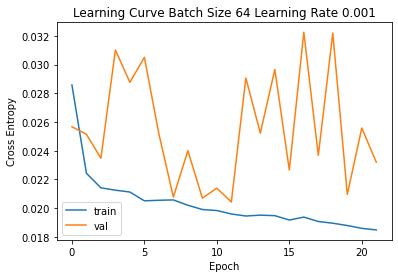

In [14]:
plot_loss(histories[0], 64, 0.001)

True